In [1]:
!rm -r /kaggle
!rm -r /input

rm: cannot remove '/kaggle/input': Device or resource busy
rm: cannot remove '/input': No such file or directory


In [2]:
!mkdir /input
!mkdir /kaggle
!mkdir /kaggle/working

mkdir: cannot create directory ‘/kaggle’: File exists


In [3]:
# general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output

dataset_path = "../input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 6.8 MB/s eta 0:00:00


In [4]:
import os
from google.colab import files

files.upload()

dataset = 'lfw-dataset'

!rm -r $dataset

!rm -r ~/.kaggle
!mkdir ~/.kaggle

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/lfw-dataset

zip_file = f"{dataset}.zip"
destination_dir = f"../input/lfw-dataset"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

Saving kaggle (1).json to kaggle (1).json
rm: cannot remove 'lfw-dataset': No such file or directory
rm: cannot remove '/root/.kaggle': No such file or directory
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jessicali9530/lfw-dataset
License(s): other
 93% 105M/112M [00:01<00:00, 80.8MB/s] 
100% 112M/112M [00:01<00:00, 70.6MB/s]


In [5]:

lfw_allnames = pd.read_csv("../input/lfw-dataset/lfw_allnames.csv")
matchpairsDevTest = pd.read_csv("../input/lfw-dataset/matchpairsDevTest.csv")
matchpairsDevTrain = pd.read_csv("../input/lfw-dataset/matchpairsDevTrain.csv")
mismatchpairsDevTest = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTest.csv")
mismatchpairsDevTrain = pd.read_csv("../input/lfw-dataset/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("../input/lfw-dataset/pairs.csv")
# tidy pairs data:
pairs = pairs.rename(columns ={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs["name2"].isnull()].drop("name2",axis=1)
mismatched_pairs = pairs[pairs["name2"].notnull()]
people = pd.read_csv("../input/lfw-dataset/people.csv")
# remove null values
people = people[people.name.notnull()]
peopleDevTest = pd.read_csv("../input/lfw-dataset/peopleDevTest.csv")
peopleDevTrain = pd.read_csv("../input/lfw-dataset/peopleDevTrain.csv")

In [6]:
# shape data frame so there is a row per image, matched to relevant jpg file
image_paths = lfw_allnames.loc[lfw_allnames.index.repeat(lfw_allnames['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", axis=1)

# take a random sample: 80% of the data for the test set
lfw_train, lfw_test = train_test_split(image_paths, test_size=0.2)
lfw_train = lfw_train.reset_index().drop("index", axis=1)
lfw_test = lfw_test.reset_index().drop("index",axis=1)

# verify that there is a mix of seen and unseen individuals in the test set
print(len(set(lfw_train.name).intersection(set(lfw_test.name))))
print(len(set(lfw_test.name) - set(lfw_train.name)))

844
852


<Axes: xlabel='name'>

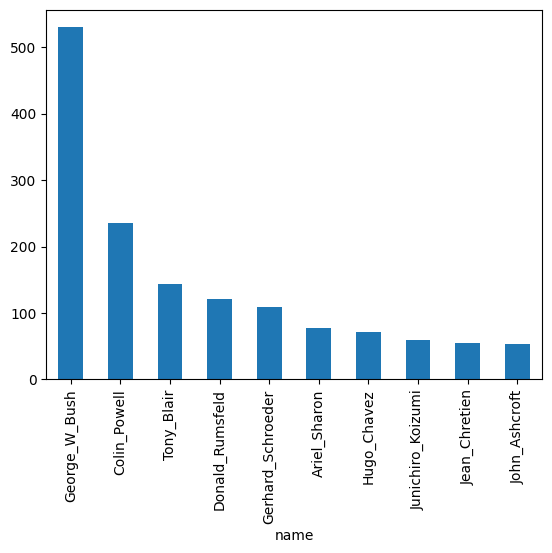

In [7]:
top_10_names = image_paths['name'].value_counts()[:10].index

# Filter the DataFrame to only include rows where 'name' is in the top 10
image_paths = image_paths[image_paths['name'].isin(top_10_names)]
image_paths['name'].value_counts()[:10].plot(kind = "bar")

In [8]:
image_paths['name'].value_counts()[:10]

name
George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Hugo_Chavez           71
Junichiro_Koizumi     60
Jean_Chretien         55
John_Ashcroft         53
Name: count, dtype: int64

In [9]:
multi_data = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                        image_paths[image_paths.name=="Colin_Powell"].sample(75),
                        image_paths[image_paths.name=="Tony_Blair"].sample(75),
                        image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                        image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                        image_paths[image_paths.name=="Ariel_Sharon"].sample(75),
                        image_paths[image_paths.name=="Hugo_Chavez"].sample(71),
                        image_paths[image_paths.name=="Junichiro_Koizumi"].sample(60),
                        image_paths[image_paths.name=="Jean_Chretien"].sample(55),
                        image_paths[image_paths.name=="John_Ashcroft"].sample(53)
                        ]
                       )

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

def extract_features(image_paths):
    features = []
    for path in image_paths:
        img = cv2.imread(dataset_path + path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (100, 100))  # Resize for consistency
        features.append(img.flatten())
    return features

# Extract features for both train and test sets
top_10_names = image_paths['name'].value_counts()[:10].index

# Filter the train and test DataFrames to only include rows where 'name' is in the top 10
lfw_train_top_10 = lfw_train[lfw_train['name'].isin(top_10_names)]
lfw_test_top_10 = lfw_test[lfw_test['name'].isin(top_10_names)]

# Extract features for both train and test sets
X_train = extract_features(lfw_train_top_10['image_path'])
X_test = extract_features(lfw_test_top_10['image_path'])

# Label Encoding:
le = LabelEncoder()
y_train = le.fit_transform(lfw_train_top_10['name'])
y_test = le.transform(lfw_test_top_10['name'])  # Use transform, not fit_transform

# KNN Classifier:
k = 5  # You can experiment with this value
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [11]:
from sklearn.metrics import accuracy_score
y_pred_test = knn.predict(X_test) # Predictions for the Test set
y_pred_train = knn.predict(X_train) # Predictions for the Train set

test_accuracy = accuracy_score(y_test, y_pred_test)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f'Testing Accuracy: {test_accuracy*100:.2f}%')
print(f'Training Accuracy: {train_accuracy*100:.2f}%')

Testing Accuracy: 39.80%
Training Accuracy: 63.37%


Saving Screenshot 2024-05-30 024851.png to Screenshot 2024-05-30 024851.png


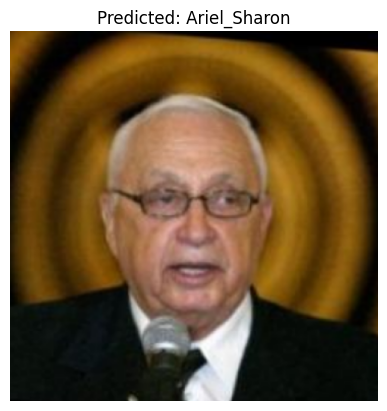

In [12]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
# Upload the image
uploaded = files.upload()

# Get the path of the uploaded image
image_path = next(iter(uploaded))

# Read and preprocess the image
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (100, 100))  # Resize for consistency
img_features = img.flatten().reshape(1, -1)

# Predict the label of the image
predicted_label = knn.predict(img_features)

# Get the name corresponding to the predicted label
predicted_name = le.inverse_transform(predicted_label)



# Read the image using matplotlib
img = plt.imread(image_path)

# Plot the image
plt.imshow(img, cmap='gray')
plt.title(f"Predicted: {predicted_name[0]}")
plt.axis('off')  # to hide the axis
plt.show()